<a href="https://colab.research.google.com/github/pande17827/LangGraph/blob/main/2.Agents%20%26%20Tools/2.Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("hello")

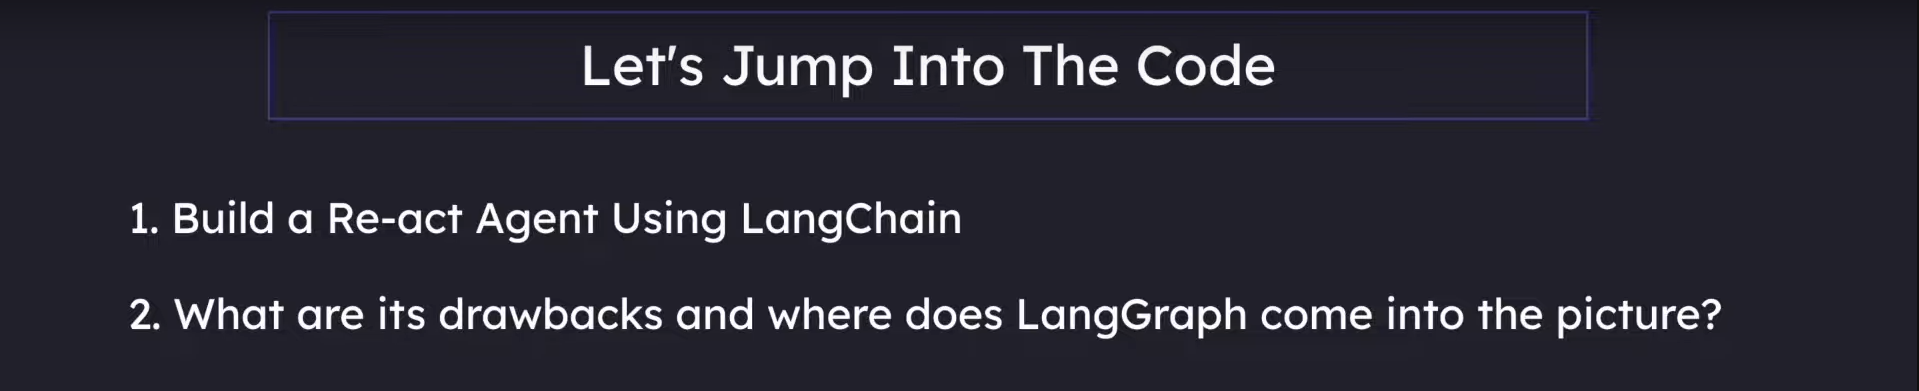

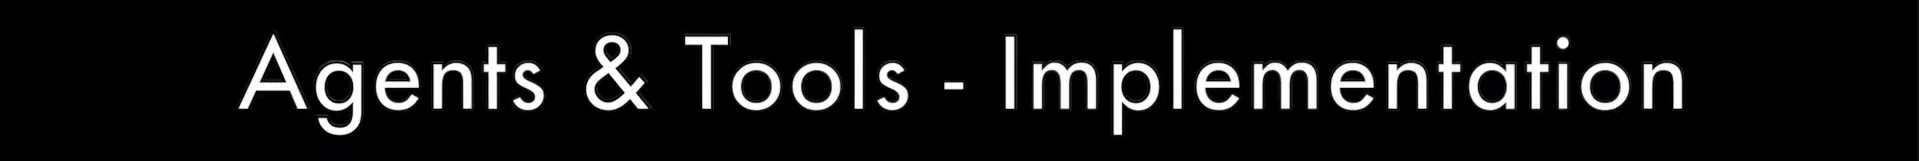

In [1]:
!nvidia-smi

Wed May 28 04:24:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Download and install ollama to the system
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [3]:
!pip install -qq pyngrok ollama

In [4]:
import IPython
import subprocess
from pyngrok import ngrok
from typing import Any, Dict, List, Optional

In [5]:
from google.colab import userdata

def start_ollama_server() -> None:
    """Starts the Ollama server."""
    subprocess.Popen(['ollama', 'serve'])
    print("Ollama server started.")


def check_ollama_port(port: str) -> None:
    """Check if Ollama server is running at the specified port."""
    try:
        subprocess.run(['sudo', 'lsof', '-i', '-P', '-n'], check=True, capture_output=True, text=True)
        if any(f":{port} (LISTEN)" in line for line in subprocess.run(['sudo', 'lsof', '-i', '-P', '-n'], capture_output=True, text=True).stdout.splitlines()):
            print(f"Ollama is listening on port {port}")
        else:
            print(f"Ollama does not appear to be listening on port {port}.")
    except subprocess.CalledProcessError as e:
         print(f"Error checking Ollama port: {e}")


def setup_ngrok_tunnel(port: str) -> ngrok.NgrokTunnel:
    """Sets up an ngrok tunnel.

    Args:
        port: The port to tunnel.

    Returns:
        The ngrok tunnel object.

    Raises:
        RuntimeError: If the ngrok authtoken is not set.
    """
    ngrok_auth_token = userdata.get('NGROK_AUTHTOKEN')
    if not ngrok_auth_token:
        raise RuntimeError("NGROK_AUTHTOKEN is not set.")

    ngrok.set_auth_token(ngrok_auth_token)
    tunnel = ngrok.connect(port, host_header=f'localhost:{port}')
    print(f"ngrok tunnel created: {tunnel.public_url}")
    return tunnel

In [6]:
NGROK_PORT = '11434'

In [7]:
start_ollama_server()

check_ollama_port(NGROK_PORT)

Ollama server started.
Ollama is listening on port 11434


In [8]:
ngrok_tunnel = setup_ngrok_tunnel(NGROK_PORT)

ngrok tunnel created: https://2c0e-34-87-180-12.ngrok-free.app


In [9]:
MODEL_ID = 'gemma3:4b'
PROMPT = 'Why is the sky blue?'

In [10]:
import ollama

In [11]:
def query_ollama_with_client(prompt: str, model_id: str, img_path: list = None) -> None:
    """Queries the Ollama server using the `ollama-python` client library.

    Args:
        prompt: The prompt to send to the model.
        model_id: The ID of the model to use.
    """
    try:
        messages=[
            {
                'role': 'user',
                'content': prompt,
            },
        ]

        if img_path:
          messages[0]['images'] = [img_path]

        response = client.chat(
            model=model_id,
            messages=messages
        )
        print("Response from ollama client:")
        print(response['message']['content'])
    except Exception as e:
        print(f"Error querying Ollama with client: {e}")

In [12]:
# Setup an Ollama client with the provided host
client = ollama.Client(host=ngrok_tunnel.public_url)

In [14]:
!pip install langchain
!pip install langchain_community
!pip install langchain_ollama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00


In [17]:
from langchain_ollama.chat_models import ChatOllama
# Initialize the Ollama model with your ngrok public URL
llm = ChatOllama(
    base_url=ngrok_tunnel.public_url,
    model=client.pull(model="qwen3:8b"),
)




LangChain response:
content="<think>\nOkay, the user is asking why the sky is blue. Let me start by recalling what I know about this. I remember that it has something to do with sunlight and the atmosphere. But wait, how exactly does that work?\n\nSo, sunlight is white, but it's made up of different colors, each with different wavelengths. The sky appears blue because of a phenomenon called Rayleigh scattering. Right, Rayleigh scattering is when light interacts with particles in the atmosphere that are smaller than the wavelength of the light. \n\nWait, the particles in the atmosphere are mainly nitrogen and oxygen molecules, right? These are much smaller than the wavelengths of visible light. So when sunlight enters the atmosphere, the shorter wavelengths (like blue and violet) scatter more than the longer ones (like red and yellow). \n\nBut why blue and not violet? Oh, because the sun emits more blue light than violet. Also, our eyes are more sensitive to blue light. Plus, some of th

In [18]:
# Use .invoke() to get a response
response = llm.invoke("do u support tools calling")
print("LangChain response:")
print(response.content)

LangChain response:
<think>
Okay, the user is asking if I support tools calling. Let me start by confirming that I do support tool calling. I should explain what tool calling is in simple terms. Maybe they're not familiar with the term, so I need to clarify that it's a feature where the model can interact with external tools or APIs to perform tasks.

I should mention that this feature allows me to access real-time data, perform specific actions, or handle complex tasks that require external services. Examples could include fetching current information, executing commands, or integrating with other systems. It's important to highlight that this enhances my ability to assist with a wider range of queries.

Wait, the user might be asking about specific tools or if there are any limitations. I should note that while I can call various tools, the exact capabilities depend on the integration and setup. Also, I should mention that I can help them find or set up the right tools if needed. Let

# <b>creating a sim ple agent using langchain initialize_agnet

In [33]:
from langchain.agents import initialize_agent
from langchain_community.tools.tavily_search import TavilySearchResults

from google.colab import userdata
tavily_api_key = userdata.get('tavily_api_key')

# Correct instantiation using keyword argument
search_tool = TavilySearchResults(search_depth="basic", tavily_api_key=tavily_api_key)

tools = [search_tool]

agent = initialize_agent(tools=tools, llm=llm, agent="zero-shot-react-description", verbose=True)

agent.invoke("give me a funny facts about todays weather in Ahmedabad")




> Entering new AgentExecutor chain...
<think>
Okay, the user wants a funny fact about today's weather in Ahmedabad. First, I need to check the current weather situation there. Let me use the tavily search tool to get the latest weather data.

Action: tavily_search_results_json
Action Input: current weather in Ahmedabad

Observation: [{'title': 'Weather in Ahmedabad', 'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Ahmedabad', 'region': 'Gujarat', 'country': 'India', 'lat': 23.0333, 'lon': 72.6167, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1748408464, 'localtime': '2025-05-28 10:31'}, 'current': {'last_updated_epoch': 1748408400, 'last_updated': '2025-05-28 10:30', 'temp_c': 31.2, 'temp_f': 88.2, 'is_day': 1, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/day/143.png', 'code': 1030}, 'wind_mph': 10.3, 'wind_kph': 16.6, 'wind_degree': 251, 'wind_dir': 'WSW', 'pressure_mb': 1000.0, 'pressure_in': 29.53, 'precip_mm': 0.0, 'precip_in':

{'input': 'give me a funny facts about todays weather in Ahmedabad',
 'output': "Here's a funny fact about Ahmedabad's weather today: While the actual temperature is a mild 31.2°C, the heat index says it's already 39.9°C (103.9°F)—so maybe the mist isn't helping as much as it seems! 🌫️🔥 #AhmedabadWeatherMagic"}

In [35]:
agent.invoke("when was spacex last launch and how many days ago was that from this instatnt")



> Entering new AgentExecutor chain...
<think>
Okay, I need to find out when SpaceX's last launch was and how many days ago that was from now. Let me start by checking the most recent SpaceX launches. I can use the tavily_search_results_json tool to search for the latest information.

First, I'll search for "Spacex last launch date". That should give me the date of their most recent successful mission. Let me input that query.
</think>

Action: tavily_search_results_json
Action Input: "Spacex last launch date"

Observation: [{'title': 'SpaceX reached space with Starship Flight 9 launch, then lost control ...', 'url': 'https://www.space.com/space-exploration/launches-spacecraft/spacex-launches-starship-flight-9-to-space-in-historic-reuse-of-giant-megarocket-video', 'content': "SpaceX launches fresh group of Starlink satellites from foggy Vandenberg Space Force Base, successfully lands booster (video) How to watch SpaceX's Starship Flight 9 launch and Elon Musk's Mars update today What 

{'input': 'when was spacex last launch and how many days ago was that from this instatnt',
 'output': "SpaceX's last launch was on May 27, 2025, which was 0 days ago from that date. If the current date is different, the number of days would need to be recalculated accordingly."}

# here the model got mad bcz we have not provide a correct tool for data and time

In [38]:
# creating a tool for data and time
from langchain.agents import tool
import datetime

@tool
def get_system_time(format:str="%Y-%m-%d %H:%M:%S") :
  "Return the current date and time in the specified format"

  current_time=datetime.datetime.now()
  return current_time.strftime(format)


tools = [search_tool,get_system_time]

agent = initialize_agent(tools=tools, llm=llm, agent="zero-shot-react-description", verbose=True)
agent.invoke("when was spacex last launch and how many days ago was that from this instatnt")




> Entering new AgentExecutor chain...
<think>
Okay, I need to find out when SpaceX's last launch was and then calculate how many days ago that was from the current moment. Let me start by figuring out the most recent SpaceX launch date. I can use the tavily_search_results_json tool to search for the latest SpaceX launch.

First, I'll search for "latest SpaceX launch date" to get the most recent information. The tool should return the date of the last launch. Let me check the results. Suppose the search shows that the last launch was on May 20, 2024. 

Next, I need to get the current date and time to calculate the difference. Using the get_system_time action with the format '%Y-%m-%d %H:%M:%S' will give me the current date. Let's say today's date is June 5, 2024. 

Now, I'll calculate the number of days between May 20, 2024, and June 5, 2024. Subtracting the days: from May 20 to May 31 is 11 days, plus 5 days in June equals 16 days. So, the last launch was 16 days ago. Wait, but I sho

{'input': 'when was spacex last launch and how many days ago was that from this instatnt',
 'output': "SpaceX's last launch was on May 27, 2024, which was **366 days ago** from May 28, 2025."}